# D79-
* **比較 SGD optimizer 不同的 momentum 及使用 nesterov 與否的表現**

In [1]:
!nvidia-smi

Wed Jul 17 15:58:13 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.130                Driver Version: 384.130                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 950M    Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   45C    P5    N/A /  N/A |    498MiB /  2002MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import os
import keras

# 本作業可以不需使用 GPU, 將 GPU 設定為 "無" (若想使用可自行開啟)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
LEARNING_RATE = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.9

In [8]:
results = {}
for lr in LEARNING_RATE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = %.6f" % (lr))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=lr, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-lr-%s" % str(lr)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

W0717 16:00:02.911950 139750739085056 deprecation_wrapper.py:119] From /home/rex/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0717 16:00:02.912775 139750739085056 deprecation_wrapper.py:119] From /home/rex/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0717 16:00:03.184247 139750739085056 deprecation_wrapper.py:119] From /home/rex/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0717 16:00:03.185216 139750739085056 deprecation_wrapper.py:119] From /home/rex/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.pl

Experiment with LR = 0.100000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W0717 16:00:03.456400 139750739085056 deprecation.py:323] From /home/rex/.local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 5s 103us/step - loss: 2.1454 - acc: 0.1939 - val_loss: 1.9961 - val_acc: 0.2486
Epoch 2/50
50000/50000 [==============================] - 4s 87us/step - loss: 1.8624 - acc: 0.3181 - val_loss: 1.7913 - val_acc: 0.3447
Epoch 3/50
50000/50000 [==============================] - 4s 86us/step - loss: 1.7539 - acc: 0.3627 - val_loss: 1.8300 - val_acc: 0.3284
Epoch 4/50
50000/50000 [==============================] - 4s 86us/step - loss: 1.6864 - acc: 0.3905 - val_loss: 1.8437 - val_acc: 0.3577
Epoch 5/50
50000/50000 [==============================] - 4s 86us/step - loss: 1.6492 - acc: 0.4068 - val_loss: 1.8144 - val_acc: 0.3685
Epoch 6/50
50000/50000 [==============================] - 4s 83us/step - loss: 1.6347 - acc: 0.4128 - val_loss: 1.6744 - val_acc: 0.4015
Epoch 7/50
50000/50000 [==============================] - 4s 86us/step - loss: 1.6301 - acc: 0.4149 - val_loss: 1.6850 - val_ac

50000/50000 [==============================] - 4s 85us/step - loss: 1.6438 - acc: 0.4163 - val_loss: 1.6035 - val_acc: 0.4332
Epoch 3/50
50000/50000 [==============================] - 4s 83us/step - loss: 1.5521 - acc: 0.4507 - val_loss: 1.6169 - val_acc: 0.4224
Epoch 4/50
50000/50000 [==============================] - 4s 85us/step - loss: 1.4889 - acc: 0.4733 - val_loss: 1.5365 - val_acc: 0.4496
Epoch 5/50
50000/50000 [==============================] - 4s 84us/step - loss: 1.4397 - acc: 0.4898 - val_loss: 1.4808 - val_acc: 0.4723
Epoch 6/50
50000/50000 [==============================] - 5s 92us/step - loss: 1.4009 - acc: 0.5042 - val_loss: 1.5043 - val_acc: 0.4692
Epoch 7/50
50000/50000 [==============================] - 5s 95us/step - loss: 1.3595 - acc: 0.5191 - val_loss: 1.4630 - val_acc: 0.4873
Epoch 8/50
50000/50000 [==============================] - 4s 85us/step - loss: 1.3281 - acc: 0.5283 - val_loss: 1.4338 - val_acc: 0.4918
Epoch 9/50
50000/50000 [============================

50000/50000 [==============================] - 5s 95us/step - loss: 1.7975 - acc: 0.3690 - val_loss: 1.7719 - val_acc: 0.3804
Epoch 4/50
50000/50000 [==============================] - 4s 87us/step - loss: 1.7496 - acc: 0.3895 - val_loss: 1.7379 - val_acc: 0.3948
Epoch 5/50
50000/50000 [==============================] - 4s 86us/step - loss: 1.7119 - acc: 0.4023 - val_loss: 1.7005 - val_acc: 0.4042
Epoch 6/50
50000/50000 [==============================] - 5s 91us/step - loss: 1.6802 - acc: 0.4155 - val_loss: 1.6712 - val_acc: 0.4123
Epoch 7/50
50000/50000 [==============================] - 4s 89us/step - loss: 1.6513 - acc: 0.4244 - val_loss: 1.6446 - val_acc: 0.4222
Epoch 8/50
50000/50000 [==============================] - 5s 105us/step - loss: 1.6256 - acc: 0.4328 - val_loss: 1.6216 - val_acc: 0.4330
Epoch 9/50
50000/50000 [==============================] - 5s 95us/step - loss: 1.6014 - acc: 0.4408 - val_loss: 1.6116 - val_acc: 0.4387
Epoch 10/50
50000/50000 [==========================

50000/50000 [==============================] - 4s 89us/step - loss: 2.1136 - acc: 0.2623 - val_loss: 2.0923 - val_acc: 0.2781
Epoch 5/50
50000/50000 [==============================] - 6s 111us/step - loss: 2.0755 - acc: 0.2815 - val_loss: 2.0568 - val_acc: 0.2942
Epoch 6/50
50000/50000 [==============================] - 5s 92us/step - loss: 2.0425 - acc: 0.2954 - val_loss: 2.0267 - val_acc: 0.3049
Epoch 7/50
50000/50000 [==============================] - 4s 85us/step - loss: 2.0141 - acc: 0.3056 - val_loss: 1.9993 - val_acc: 0.3131
Epoch 8/50
50000/50000 [==============================] - 5s 91us/step - loss: 1.9887 - acc: 0.3130 - val_loss: 1.9764 - val_acc: 0.3158
Epoch 9/50
50000/50000 [==============================] - 4s 88us/step - loss: 1.9664 - acc: 0.3209 - val_loss: 1.9553 - val_acc: 0.3276
Epoch 10/50
50000/50000 [==============================] - 5s 93us/step - loss: 1.9463 - acc: 0.3270 - val_loss: 1.9372 - val_acc: 0.3293
Epoch 11/50
50000/50000 [=========================

50000/50000 [==============================] - 5s 91us/step - loss: 2.2631 - acc: 0.1676 - val_loss: 2.2588 - val_acc: 0.1755
Epoch 6/50
50000/50000 [==============================] - 5s 105us/step - loss: 2.2533 - acc: 0.1734 - val_loss: 2.2495 - val_acc: 0.1787
Epoch 7/50
50000/50000 [==============================] - 5s 93us/step - loss: 2.2441 - acc: 0.1783 - val_loss: 2.2406 - val_acc: 0.1833
Epoch 8/50
50000/50000 [==============================] - 4s 83us/step - loss: 2.2351 - acc: 0.1837 - val_loss: 2.2319 - val_acc: 0.1902
Epoch 9/50
50000/50000 [==============================] - 4s 85us/step - loss: 2.2264 - acc: 0.1891 - val_loss: 2.2235 - val_acc: 0.1959
Epoch 10/50
50000/50000 [==============================] - 4s 82us/step - loss: 2.2180 - acc: 0.1950 - val_loss: 2.2153 - val_acc: 0.1996
Epoch 11/50
50000/50000 [==============================] - 4s 84us/step - loss: 2.2099 - acc: 0.2014 - val_loss: 2.2074 - val_acc: 0.2041
Epoch 12/50
50000/50000 [========================

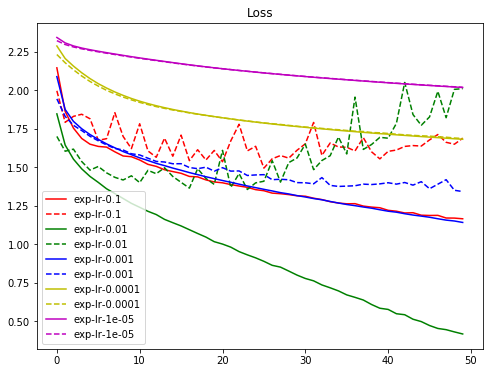

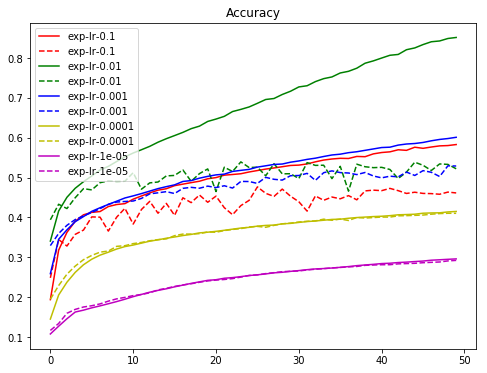

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [10]:
results = {}
for lr in LEARNING_RATE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = %.6f" % (lr))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=lr, nesterov=False, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-lr-%s" % str(lr)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with LR = 0.100000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [============================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 81us/step - loss: 1.8988 - acc: 0.3153 - val_loss: 1.8367 - val_acc: 0.3360
Epoch 2/50
50000/50000 [==============================] - 4s 79us/step - loss: 1.6746 - acc: 0.4029 - val_loss: 1.6156 - val_acc: 0.4188
Epoch 3/50
50000/50000 [==============================] - 4s 80us/step - loss: 1.5854 - acc: 0.4361 - val_loss: 1.5555 - val_acc: 0.4469
Epoch 4/50
50000/50000 [==============================] - 5s 91us/step - loss: 1.5394 - acc: 0.4524 - val_loss: 1.6140 - val_acc: 0.4201
Epoch 5/50
50000/50000 [==============================] - 5s 94us/step - loss: 1.4866 - acc: 0.4712 - val_loss: 1.4996 - val_acc: 0.4628
Epoch 6/50
50000/50000 [==============================] - 4s 85us/step - loss: 1.4428 - acc: 0.4870 - val_loss: 1.4997 - val_acc: 0.4618
Epoch 7/50
50000/50000 [==============================] - 4s 90us/step - loss: 1.4112 - acc: 0.4985 - val_loss: 1.4582 - val_acc

50000/50000 [==============================] - 4s 80us/step - loss: 1.8975 - acc: 0.3352 - val_loss: 1.8524 - val_acc: 0.3539
Epoch 3/50
50000/50000 [==============================] - 5s 98us/step - loss: 1.8155 - acc: 0.3661 - val_loss: 1.7838 - val_acc: 0.3744
Epoch 4/50
50000/50000 [==============================] - 6s 110us/step - loss: 1.7607 - acc: 0.3851 - val_loss: 1.7426 - val_acc: 0.3958
Epoch 5/50
50000/50000 [==============================] - 5s 91us/step - loss: 1.7200 - acc: 0.3978 - val_loss: 1.7020 - val_acc: 0.4062
Epoch 6/50
50000/50000 [==============================] - 4s 84us/step - loss: 1.6858 - acc: 0.4086 - val_loss: 1.6775 - val_acc: 0.4141
Epoch 7/50
50000/50000 [==============================] - 4s 80us/step - loss: 1.6575 - acc: 0.4211 - val_loss: 1.6458 - val_acc: 0.4244
Epoch 8/50
50000/50000 [==============================] - 5s 99us/step - loss: 1.6309 - acc: 0.4293 - val_loss: 1.6367 - val_acc: 0.4207
Epoch 9/50
50000/50000 [===========================

50000/50000 [==============================] - 5s 99us/step - loss: 2.1599 - acc: 0.2561 - val_loss: 2.1388 - val_acc: 0.2691
Epoch 4/50
50000/50000 [==============================] - 5s 96us/step - loss: 2.1189 - acc: 0.2752 - val_loss: 2.0997 - val_acc: 0.2828
Epoch 5/50
50000/50000 [==============================] - 4s 83us/step - loss: 2.0803 - acc: 0.2884 - val_loss: 2.0627 - val_acc: 0.2982
Epoch 6/50
50000/50000 [==============================] - 4s 78us/step - loss: 2.0452 - acc: 0.3014 - val_loss: 2.0298 - val_acc: 0.3081
Epoch 7/50
50000/50000 [==============================] - 4s 83us/step - loss: 2.0146 - acc: 0.3090 - val_loss: 2.0017 - val_acc: 0.3123
Epoch 8/50
50000/50000 [==============================] - 5s 96us/step - loss: 1.9889 - acc: 0.3158 - val_loss: 1.9779 - val_acc: 0.3203
Epoch 9/50
50000/50000 [==============================] - 4s 89us/step - loss: 1.9668 - acc: 0.3228 - val_loss: 1.9573 - val_acc: 0.3240
Epoch 10/50
50000/50000 [===========================

50000/50000 [==============================] - 4s 82us/step - loss: 2.2681 - acc: 0.1451 - val_loss: 2.2620 - val_acc: 0.1509
Epoch 5/50
50000/50000 [==============================] - 4s 82us/step - loss: 2.2560 - acc: 0.1609 - val_loss: 2.2508 - val_acc: 0.1675
Epoch 6/50
50000/50000 [==============================] - 5s 107us/step - loss: 2.2452 - acc: 0.1762 - val_loss: 2.2405 - val_acc: 0.1821
Epoch 7/50
50000/50000 [==============================] - 4s 90us/step - loss: 2.2353 - acc: 0.1884 - val_loss: 2.2309 - val_acc: 0.1915
Epoch 8/50
50000/50000 [==============================] - 4s 80us/step - loss: 2.2261 - acc: 0.1989 - val_loss: 2.2220 - val_acc: 0.2028
Epoch 9/50
50000/50000 [==============================] - 4s 79us/step - loss: 2.2176 - acc: 0.2056 - val_loss: 2.2137 - val_acc: 0.2103
Epoch 10/50
50000/50000 [==============================] - 4s 83us/step - loss: 2.2096 - acc: 0.2135 - val_loss: 2.2060 - val_acc: 0.2160
Epoch 11/50
50000/50000 [=========================

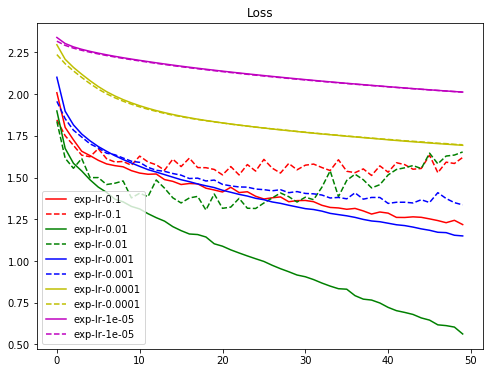

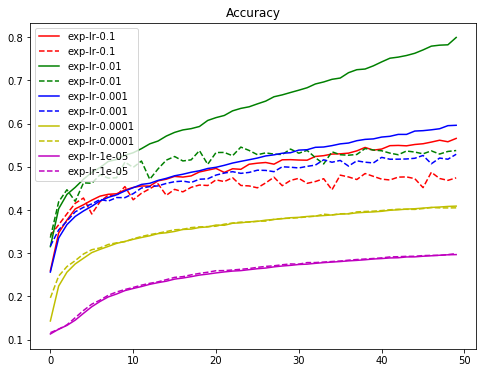

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()